# Import and Setup

### Adjusting cell width

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Choose version of Discovery Potential Calculation to run

In [2]:
version = 37

In [3]:
import pandas as pd 
pd.set_option('display.max_colwidth', 200)
dp_csv = pd.read_csv('/p/lustre1/jamil1/sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential/dp_versions.csv', usecols=[0,1,2,3,4,8])
dp_version = dp_csv[dp_csv['Name'].str.contains("Version %d" % version)]

### Import useful libraries for analysis

In [4]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st

### Import the nEXO sensitivity classes

In [5]:
import sys
sys.path.append('/p/lustre1/jamil1/sensitivity/modules')

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

### Adjusting plots

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', '#F29F05', '#7155D9', 
          '#8D07F6', '#9E91F2', '#F29B9B', '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']

### Useful functions

This function sorts a list of strings in a natural way, i.e. '10' comes after '1'. 

In [7]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

This function uses the isotopic abundance of Xe-136 and Xe-134 and their respective molar masses to calculate the number of Xe-136 atoms in any given fiducial mass. Combined with a predetermined signal efficiency it returns the expected lower limit on the half-life.

In [8]:
mmass_xe136 = 135.907214 # in gram/mol 
mmass_xe134 = 133.905393 # in gram/mol 
Avogadro = 6.02214076E23 # in 1/mol
bb0n_eff = 0.963
XeMass_fiducial = 3281.0*1000.0 # in gram
frac_136 = 0.9
frac_134 = 0.1

def GetLivetime(Num, Livetime):
    NXenon136 = (XeMass_fiducial * Avogadro * frac_136) / (frac_136 * mmass_xe136 + frac_134  * mmass_xe134)
    return bb0n_eff * NXenon136 * Livetime  * np.log(2.0) / Num

# Data Read-In
Define directory from where to read in the data and select only HDF5 files.

In [9]:
PlotDir = '/p/lustre1/jamil1/sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential/plots/version%d/' % version
DataDir = '/p/vast1/nexo/sensitivity2020/data/DiscoveryPotential/version%d/h5/' % version
DataDir = str(dp_version['Data Directory'].to_numpy()[0])+'/h5/'
print(DataDir)
# print(dp_csv)

if not os.path.isdir(PlotDir):
    os.makedirs(PlotDir)

AllFiles = os.listdir(DataDir)
H5Files = [filename for filename in AllFiles if filename.endswith('.h5')]
print('Number of files {}'.format(len(H5Files)))

/p/vast1/jamil1/sensitivity2020/data/DiscoveryPotential/version37//h5/
Number of files 1300


For all HDF5 files that were found in the above directory we want to sort them by simulated livetime of the experiment and mean number of signal counts that were used in the toy datasets. The filename follows this naming convention: DiscoverPotential_bb0n_[num]ct_[Livetime]yrs.h5 where num is the mean number of signal counts in the toy datasets and Livetime is the simulated livetime of nEXO.

In [10]:
AllLivetimes = np.arange(0.1,10.01,0.1)
AllLivetimes = [10.0]
Livetimes = []
Tags = {}
for ii,Livetime in enumerate(AllLivetimes):
    Tags[Livetime] = natural_sort(np.unique(['_'.join(x.split('_')[:3])+'_%.1fyrs' % Livetime for x in H5Files if '%.1fyrs' % Livetime in x]))
    if len(Tags[Livetime]) < 1: 
        del Tags[AllLivetimes[ii]]
        continue
    else:
        Livetimes.append(Livetime)
    print(Livetime, Tags[Livetime])

10.0 ['DiscoveryPotential_bb0n_0ct_10.0yrs', 'DiscoveryPotential_bb0n_10ct_10.0yrs', 'DiscoveryPotential_bb0n_12ct_10.0yrs', 'DiscoveryPotential_bb0n_14ct_10.0yrs', 'DiscoveryPotential_bb0n_16ct_10.0yrs', 'DiscoveryPotential_bb0n_18ct_10.0yrs', 'DiscoveryPotential_bb0n_20ct_10.0yrs']


Sorting by mean number of signal counts and livetime we read in the data into a python dictionary of pandas DataFrames. 

In [11]:
dfdict = {}

for Livetime in Livetimes: 
    print('='*15 + '   {} yr of livetime   '.format(Livetime) + '='*15)
    dfdict[Livetime] = {}
    for category in Tags[Livetime]:
        df_list = [pd.read_hdf(DataDir+filename) for filename in H5Files if category in filename]
        dfdict[Livetime][category] = pd.concat(df_list,ignore_index=True)
        print('Number of file for {}: {}'.format(category, len(df_list)))

===============   10.0 yr of livetime   ===============
Number of file for DiscoveryPotential_bb0n_0ct_10.0yrs: 1000
Number of file for DiscoveryPotential_bb0n_10ct_10.0yrs: 50
Number of file for DiscoveryPotential_bb0n_12ct_10.0yrs: 50
Number of file for DiscoveryPotential_bb0n_14ct_10.0yrs: 50
Number of file for DiscoveryPotential_bb0n_16ct_10.0yrs: 50
Number of file for DiscoveryPotential_bb0n_18ct_10.0yrs: 50
Number of file for DiscoveryPotential_bb0n_20ct_10.0yrs: 50


# Selection Cut
Prevent datasets from entering the distribution of test statistics for which either one of the hypothesis test fits with a fixed number of bb0n counts or the global best fit did not converge. For each tag the percentage of converged datasets will be printed.

In [12]:
maskdict = {}
count = 0
for Livetime in Livetimes: 
    print('='*15 + '   {} yr of livetime   '.format(Livetime) + '='*15)
    maskdict[Livetime] = {} 
    for key, df in dfdict[Livetime].items():
        shape_error = []
        print('Running {}'.format(key))
        good_fit_mask = []
        for index,row in df.iterrows():
            # if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 or np.sum(row['fixed_fit_converged']) < len(row['num_signal']) or not row['best_fit_covar'] or not row['best_fit_converged'] or np.min(row['lambda'])<-0.1 or np.max(np.abs(np.diff(row['lambda'])))>15:
            if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 or np.sum(row['fixed_fit_converged']) < len(row['num_signal']) or not row['best_fit_covar'] or not row['best_fit_converged'] or np.min(row['lambda'])<-0.1:
                good_fit_mask.append(False)
            else:
                good_fit_mask.append(True)

        maskdict[Livetime][key] = np.array(good_fit_mask)
        print('---> Convergence fraction: {:3.4}'.format(np.sum(maskdict[Livetime][key])/len(maskdict[Livetime][key])))     

===============   10.0 yr of livetime   ===============
Running DiscoveryPotential_bb0n_0ct_10.0yrs
---> Convergence fraction: 0.9958
Running DiscoveryPotential_bb0n_10ct_10.0yrs
---> Convergence fraction: 0.9824
Running DiscoveryPotential_bb0n_12ct_10.0yrs
---> Convergence fraction: 0.9826
Running DiscoveryPotential_bb0n_14ct_10.0yrs
---> Convergence fraction: 0.9788
Running DiscoveryPotential_bb0n_16ct_10.0yrs
---> Convergence fraction: 0.9852
Running DiscoveryPotential_bb0n_18ct_10.0yrs
---> Convergence fraction: 0.9826
Running DiscoveryPotential_bb0n_20ct_10.0yrs
---> Convergence fraction: 0.9844


# Analysis
Here we go through all the toy datasets that have passed the above selection cut and record the value of the test statistic for which the mean number of signal events in the toy dataset is 0, hence we look at the first element in the $\lambda$ curve. Since $\lambda = 2\cdot \Delta \mathrm{NNL}$ we will divide the test statistic value in the data by 2 to compute the signficance based on the $\Delta \mathrm{NNL}$ distribution. 

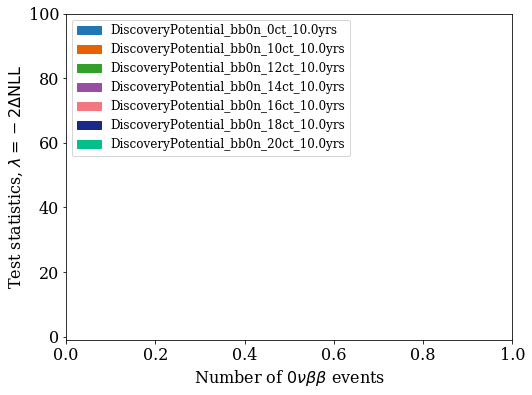

In [13]:
DeltaNLL = {}
count = 0
fig = plt.figure(figsize=(8,6))
import matplotlib.patches as mpatches
for Livetime in Livetimes: 
    DeltaNLL[Livetime] = {} 
    for key, df in dfdict[Livetime].items():
        DeltaNLL[Livetime][key] = []
        for ii,(x,y) in enumerate(zip(dfdict[Livetime][key]['num_signal'].loc[maskdict[Livetime][key]],dfdict[Livetime][key]['lambda'].loc[maskdict[Livetime][key]])):
            
            # if np.max(np.abs(np.diff(y)))>15: 
            #     print(key,ii,x,y)    
            #     plt.plot(x, y, label='toy %d' % ii, lw=1, color=colors[count])
            DeltaNLL[Livetime][key].append(y[0]/2.0)
        count += 1
plt.xlabel(r'Number of $0\nu\beta\beta$ events', fontsize=16)
plt.ylabel(r'Test statistics, $\lambda = -2\Delta\mathrm{NLL}$', fontsize=16)
plt.xlim(xmin=0)
patches = [ mpatches.Patch(color=colors[zz], label='%s'%x) for zz,x in  enumerate(dfdict[Livetime].keys())]
plt.legend(handles=patches, fontsize=12, loc='upper left')
# plt.yscale('log')
plt.ylim(-1,100)
plt.show()

The below cell does a couple of things: 
- it plots the distribution of $\Delta \mathrm{NNL}$ for all the toy datasets in which the mean number of signal in the toy dataset is 0 (shown as gray shaded histogram). This will be the distribution of our null hypothesis based on which we will compute the p-value of the alternative hypothesis for which the mean number of signal counts in the toy dataset is greater than 0.
- the distribution of $\Delta \mathrm{NNL}$ for the alternative hypotheses are plotted as colored histograms. 
- The median of each of those distributions is computed and plotted in the same color as vertical solid lines. 
- Given the median we calculate its p-value based on the null distribution (grey histogram), i.e. what is the median probability of getting a result as extreme or more extreme as this alternative hypothesis assuming the null hypothesis is true. 
- This will give a list of pairs of p-value and 

0 DiscoveryPotential_bb0n_10ct_10.0yrs 2.6458012260949832
1 DiscoveryPotential_bb0n_12ct_10.0yrs 3.3435127108439096
2 DiscoveryPotential_bb0n_14ct_10.0yrs 4.362407922640482
3 DiscoveryPotential_bb0n_16ct_10.0yrs 5.535330652478297
4 DiscoveryPotential_bb0n_18ct_10.0yrs 6.621847088992641
5 DiscoveryPotential_bb0n_20ct_10.0yrs 7.936521242525977
1 83777
1 83777 0.8413447460685429 0.38864822981791747
2 97310
2 97310 0.9772498680518208 1.8677384827725634
3 99441
3 99441 0.9986501019683699 4.237727519440253


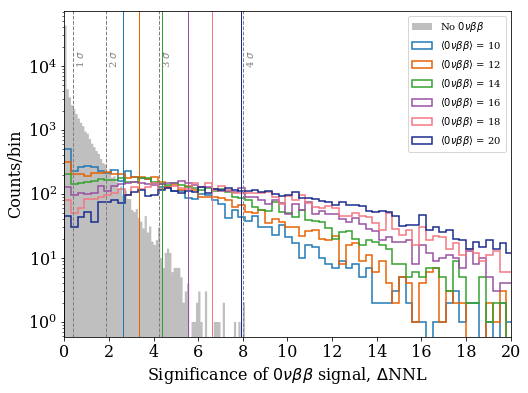

In [14]:
hist = {}
medians = {}
for Livetime in Livetimes:
    fig = plt.figure(figsize=(8,6))
    
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    FoundNull = np.char.find(list(DeltaNLL[Livetime].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Livetime].keys())[NullIndex]
    
    hist[NullSet] = plt.hist(DeltaNLL[Livetime][NullSet], 
                            bins=np.arange(0,100,0.1), 
                            label=r'No $0\nu\beta\beta$', 
                            histtype='stepfilled', 
                            color='grey', 
                            alpha=0.5)

    medians[Livetime] = []
    for ii,key in enumerate(list(DeltaNLL[Livetime].keys())[1:]):
        hist[key] = plt.hist(DeltaNLL[Livetime][key], 
                             bins=np.arange(0,100,0.3), 
                             label=r'$\langle0\nu\beta\beta\rangle$ = %s' % label[ii], 
                             histtype='step', 
                             color=colors[ii],
                             lw=1.5)
        median = np.median(DeltaNLL[Livetime][key])
        print(ii, key, median)
        plt.axvline(x=median, ymin=0, ymax=1000, ls='-', color=colors[ii])
        medians[Livetime].append(median)

    xmax = 20
    plt.xlim(0,xmax)
    plt.xticks(np.arange(0,xmax+0.1,xmax/10.0))
    plt.yscale('log')
    plt.xlabel(r'Significance of $0\nu\beta\beta$ signal, $\Delta$NNL', fontsize=16)
    plt.ylabel('Counts/bin', fontsize=16)
    plt.legend(loc='upper right', fontsize=10)

    for ii in [1,2,3]:
        index = int(np.ceil(st.norm.cdf(ii)*len(DeltaNLL[Livetime][NullSet])))
        print(ii, index)
        signif = sorted(DeltaNLL[Livetime][NullSet])[index]
        print(ii, index, st.norm.cdf(ii), signif)
        plt.axvline(x=signif, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(signif+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (ii),rotation=90, color='grey')

    # Significance assuming Wilks' theorem for sigma > 3
    # see slide 11 in https://indico.cern.ch/event/162087/contributions/235303/attachments/189340/265790/cowan_cargese_2.pdf
    for sigma in [4]:
        plt.axvline(x=sigma**2/2.0, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(sigma**2/2.0+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (sigma),rotation=90, color='grey')


    plt.savefig(PlotDir+'null_hypothesis_%dyrs_%s.png' % (Livetime,version), bbox_inches='tight', dpi=300)

In [15]:
sigma = {}
Cut = {}
XInterp = {}
Interpolation = {}

for Livetime in Livetimes:
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    FoundNull = np.char.find(list(DeltaNLL[Livetime].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Livetime].keys())[NullIndex]
    
    sorted_nll = sorted(DeltaNLL[Livetime][NullSet])
    sigma[Livetime] = []
    for ii,key in enumerate(list(DeltaNLL[Livetime].keys())[1:]):
        diff_abs = np.abs(sorted_nll - medians[Livetime][ii])
        nll_val = np.min(diff_abs)
        cut = np.where(diff_abs == nll_val)[0][0]
        sigma[Livetime].append(st.norm.ppf((cut+1)/len(sorted_nll)))
        print(ii, key, medians[Livetime][ii], cut, sorted_nll[cut], cut/len(sorted_nll), sigma[Livetime][ii])
    
    
    XInterp[Livetime] = np.linspace(int(label[0]),int(label[-1]),1000)
    Interpolation[Livetime] = np.interp(XInterp[Livetime], np.array(label).astype(int), sigma[Livetime])
    Diff = np.abs(Interpolation[Livetime] - 3.0)
    Cut[Livetime] = np.where(Diff == np.min(Diff))[0][0]


0 DiscoveryPotential_bb0n_10ct_10.0yrs 2.6458012260949832 98667 2.6454619658837486 0.9908812452924931 2.361169050467054
1 DiscoveryPotential_bb0n_12ct_10.0yrs 3.3435127108439096 99184 3.3427764269700693 0.9960733115741903 2.6591722000994076
2 DiscoveryPotential_bb0n_14ct_10.0yrs 4.362407922640482 99466 4.361967050545159 0.9989053477278433 3.066029490893723
3 DiscoveryPotential_bb0n_16ct_10.0yrs 5.535330652478297 99551 5.523114658701095 0.9997589756464976 3.501894015238408
4 DiscoveryPotential_bb0n_18ct_10.0yrs 6.621847088992641 99566 6.722460678047613 0.9999096158674367 3.7739501181579387
5 DiscoveryPotential_bb0n_20ct_10.0yrs 7.936521242525977 99572 7.897994697539569 0.9999698719558122 4.106495516281646


13.673673673673674


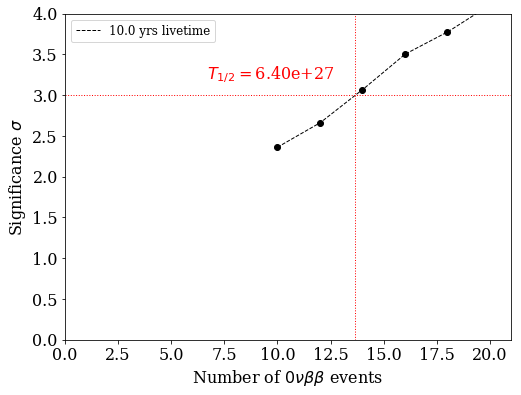

In [16]:
for Livetime in Livetimes:
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(XInterp[Livetime], Interpolation[Livetime], label='%.1f yrs livetime' % Livetime, ls='--', color='k')
    plt.scatter(np.array(label).astype(int), sigma[Livetime], color='k')
    plt.axhline(3, color='r', ls=':')
    plt.axvline(XInterp[Livetime][Cut[Livetime]], color='r', ls=':')
    print(XInterp[Livetime][Cut[Livetime]])

    plt.xlim(0,np.max(np.array(label).astype(int))+1)
    plt.ylim(0,4)
    plt.xlabel(r'Number of $0\nu\beta\beta$ events', fontsize=16)
    plt.ylabel(r'Significance $\sigma$ ', fontsize=16)
    plt.legend(loc='upper left', fontsize=12)
    plt.text(x=XInterp[Livetime][Cut[Livetime]]-7, y=3.2, s=r'$T_{1/2}=$%.2e' % GetLivetime(XInterp[Livetime][Cut[Livetime]], Livetime), color='r', fontsize=16)

    plt.savefig(PlotDir+'sigma_vs_bb0n_%dyrs_%s.png' % (Livetime,version), bbox_inches='tight', dpi=300)

Plot comparison between this study of the discovery potential vs livetime and the result from the 2018 sensitivity paper. 

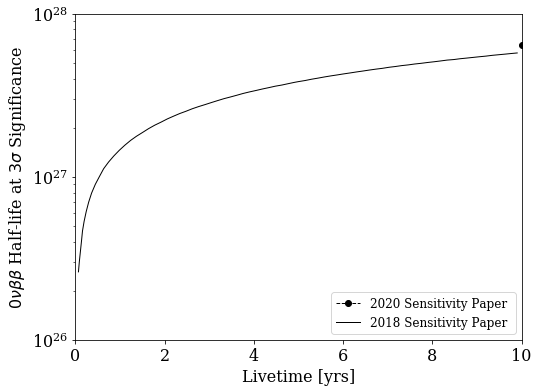

In [17]:
discovery2017 = pd.read_csv('2017_discovery_potential.csv',  header=None, usecols=[0,1])

fig = plt.figure(figsize=(8,6))
plt.plot(Livetimes, [GetLivetime(XInterp[Livetime][Cut[Livetime]], Livetime)  for Livetime in Livetimes], label='2020 Sensitivity Paper', color='k', marker='o', ls='--')
plt.plot(discovery2017[0], discovery2017[1], label='2018 Sensitivity Paper ', color='k', ls='-')

plt.xlim(0,10)
plt.ylim(1E26,1E28)
plt.yscale('log')
plt.xlabel('Livetime [yrs]')
plt.ylabel(r'$0\nu\beta\beta$ Half-life at $3\sigma$ Significance')
plt.legend(loc='lower right')

plt.savefig(PlotDir+'halflife_vs_livetime_%s.png' % (version), bbox_inches='tight', dpi=300)

Save the half-life vs livetime data in a two column csv file.

In [18]:
np.savetxt(PlotDir+'halflife_vs_livetime_%s.csv' % (version), 
            X=np.array([Livetimes, [GetLivetime(XInterp[Livetime][Cut[Livetime]], Livetime)  for Livetime in Livetimes]]).T, 
            fmt=['%.2f', '%.2e'],
            delimiter=',', 
            header='Livetime,Halflife')